In [1]:
!pip install pymc3 --user
!pip install theano --user
#!pip install statsmodels --user
#!pip install Pillow --user
#!pip uninstall scipy

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import pandas as pd
import theano

data = pd.read_csv(pm.get_data('radon.csv'))
data['log_radon'] = data['log_radon'].astype(theano.config.floatX)
county_names = data.county.unique()
county_idx = data.county_code.values

n_counties = len(data.county.unique())
data[['county', 'log_radon', 'floor']].head()

,county,log_radon,floor
0,AITKIN,0.832909,1.0
1,AITKIN,0.832909,0.0
2,AITKIN,1.098612,0.0
3,AITKIN,0.095310,0.0
4,ANOKA,1.163151,0.0


In [3]:
with pm.Model() as unpooled_model:

    # Independent parameters for each county
    a = pm.Normal('a', 0, sd=100, shape=n_counties)
    b = pm.Normal('b', 0, sd=100, shape=n_counties)

    # Model error
    eps = pm.HalfCauchy('eps', 5)

    # Model prediction of radon level
    # a[county_idx] translates to a[0, 0, 0, 1, 1, ...],
    # we thus link multiple household measures of a county
    # to its coefficients.
    radon_est = a[county_idx] + b[county_idx]*data.floor.values

    # Data likelihood
    y = pm.Normal('y', radon_est, sd=eps, observed=data.log_radon)

In [4]:
with unpooled_model:
    unpooled_trace = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, a]
Sampling 4 chains: 100%|██████████| 22000/22000 [00:25<00:00, 859.69draws/s]


In [60]:
with pm.Model() as hierarchical_model:
    # Hyperpriors for group nodes
    mu_a = pm.Normal('mu_a', mu=0., sd=100**2)
    sigma_a = pm.HalfCauchy('sigma_a', 5)
    mu_b = pm.Normal('mu_b', mu=0., sd=100**2)
    sigma_b = pm.HalfCauchy('sigma_b', 5)

    # Intercept for each county, distributed around group mean mu_a
    # Above we just set mu and sd to a fixed value while here we
    # plug in a common group distribution for all a and b (which are
    # vectors of length n_counties).
    a = pm.Normal('a', mu=mu_a, sd=sigma_a, shape=n_counties)
    # Intercept for each county, distributed around group mean mu_a
    b = pm.Normal('b', mu=mu_b, sd=sigma_b, shape=n_counties)

    # Model error
    eps = pm.HalfCauchy('eps', 5)

    radon_est = a[county_idx] + b[county_idx] * data.floor.values

    # Data likelihood
    radon_like = pm.Normal('radon_like', mu=radon_est, sd=eps, observed=data.log_radon)


You can find the C code in this temporary file: /tmp/theano_compilation_error_i_h0y1d_


Exception: ("Compilation failed (return status=1): /tmp/ccSWC9ob.s: Assembler messages:. /tmp/ccSWC9ob.s:1979: Error: no such instruction: `vinserti128 $0x1,%xmm0,%ymm1,%ymm0'. ", '[Elemwise{true_div,no_inplace}(TensorConstant{1.0}, TensorConstant{1e-08})]')

In [61]:
# Inference button (TM)!
with hierarchical_model:
    hierarchical_trace = pm.sample(draws=2000, n_init=1000)

ValueError: The model does not contain any free variables.

In [1]:
np.random.seed(1)

# number of data points
n = 200

# x locations
x = np.linspace(0, 1.5, n)

# true covariance
?_true = 0.1
?_true = 1.0
cov_func = ?_true**2 * pm.gp.cov.ExpQuad(1, ?_true)
K = cov_func(x[:,None]).eval()

# zero mean function
mean = np.zeros(n)

# sample from the gp prior
f_true = np.random.multivariate_normal(mean, K + 1e-6 * np.eye(n), 1).flatten()

# link function
def invlogit(x, eps=sys.float_info.epsilon):
    return (1.0 + 2.0 * eps) / (1.0 + np.exp(-x)) + eps

y = pm.Bernoulli.dist(p=invlogit(f_true)).random()

SyntaxError: invalid syntax (<ipython-input-1-10a68094e69c>, line 12)

In [2]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

# import some data to play with
iris = datasets.load_iris()
X = iris.data[:, :2]  # we only take the first two features.
y = np.array(iris.target, dtype=int)

h = .02  # step size in the mesh

kernel = 1.0 * RBF([1.0])
gpc_rbf_isotropic = GaussianProcessClassifier(kernel=kernel).fit(X, y)
kernel = 1.0 * RBF([1.0, 1.0])
gpc_rbf_anisotropic = GaussianProcessClassifier(kernel=kernel).fit(X, y)

# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

titles = ["Isotropic RBF", "Anisotropic RBF"]
plt.figure(figsize=(10, 5))
for i, clf in enumerate((gpc_rbf_isotropic, gpc_rbf_anisotropic)):
    # Plot the predicted probabilities. For that, we will assign a color to
    # each point in the mesh [x_min, m_max]x[y_min, y_max].
    plt.subplot(1, 2, i + 1)

    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape((xx.shape[0], xx.shape[1], 3))
    plt.imshow(Z, extent=(x_min, x_max, y_min, y_max), origin="lower")

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=np.array(["r", "g", "b"])[y],
                edgecolors=(0, 0, 0))
    plt.xlabel('Sepal length')
    plt.ylabel('Sepal width')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.title("%s, LML: %.3f" %
              (titles[i], clf.log_marginal_likelihood(clf.kernel_.theta)))

plt.tight_layout()
plt.show()

Automatically created module for IPython interactive environment


<Figure size 1000x500 with 2 Axes>

In [67]:
m = GPy.models.GPRegression(X, Y)
m

GP_regression.,value,constraints,priors
rbf.variance,1.0,+ve,
rbf.lengthscale,1.0,+ve,
Gaussian_noise.variance,1.0,+ve,


In [68]:
print(m)


Name : GP regression
Objective : 198.4141424058062
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |  value  |  constraints  |  priors
  rbf.variance             |    1.0  |      +ve      |        
  rbf.lengthscale          |    1.0  |      +ve      |        
  Gaussian_noise.variance  |    1.0  |      +ve      |        


 /N/soft/rhel6/python/intelpython3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


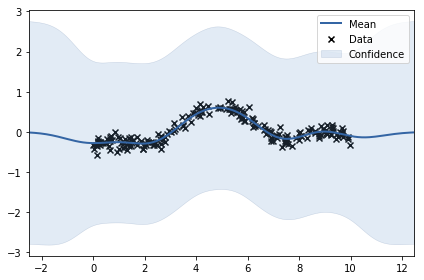

In [69]:
_ = m.plot()